# PCA for Feature Extraction, Visualization and Classification
Necessary imports and plot functions used over the entire python notebook:

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from math import log

In [2]:
# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
IMAGES_PATH = "./images"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data Retrieval and Initial Analysis

In [3]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


The functions ```plot_digit()``` and ```plot_digits()``` have been taken from [Aurélien Geron](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb)

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


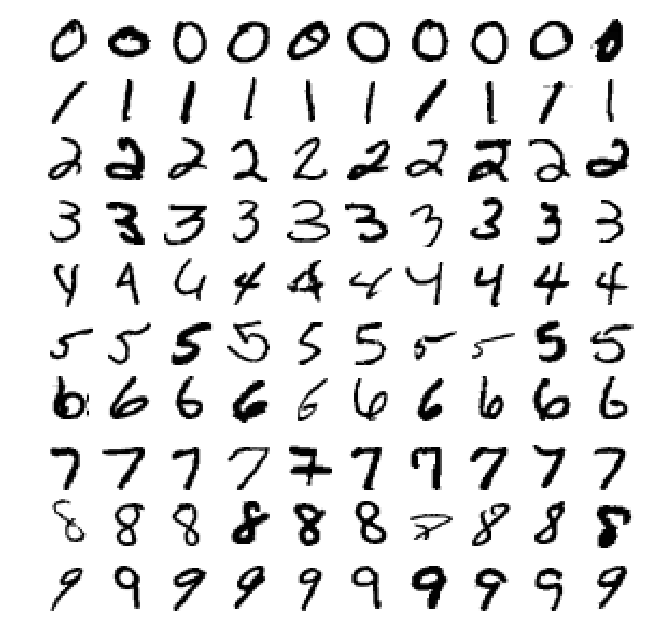

In [7]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In the MNIST database, all the digits are placed sequentially. It is important that we shuffle these digits.

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index].astype(int)

We will now look at how the data is distributed in the training data. We see that all the digits are almost equally distributed inside the dataset.

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

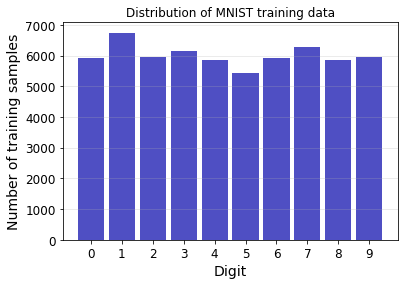

In [10]:
hist = np.bincount(y_train)
bins = np.arange(11) - 0.5
plt.hist(y_train, bins=bins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(10))
plt.xlabel('Digit')
plt.ylabel('Number of training samples')
plt.title('Distribution of MNIST training data')
hist

# Principle Component Analysis (PCA)
PCA involves the following steps:
1. Form the centered data matrix
<center>$X_{d,n} = [(x_1-\bar{x}), \ldots, (x_n-\bar{x})]$</center>

In [10]:
X_train_means = np.mean(X_train, axis=0) #caluclates mean across columns of the train set
len(X_train_means)

784

In [11]:
Xtrain_center = X_train - X_train_means

In [11]:
u,d,vT = np.linalg.svd(Xtrain_center, full_matrices=False)

### Top 2 Principle Components
Taking the first 2 principal components:

In [12]:
n_comp = 2
# Get matrix from d
sigma = np.diag(d)

#Get top n_comp components
sigma = sigma[:, :n_comp]
vT = vT[:n_comp, :]
print(sigma.shape)
print(u.shape)
print(vT.shape)

# if we want to calculate for the same matrix
Xtrain_pc2 = u.dot(sigma)
print(Xtrain_pc2.shape)

# if we were to use a new matrix and to only transform based on the PC of the earlier
Xtrain_pc2_2 = Xtrain_center.dot(vT.T)

#check if they are the same
print(np.allclose(Xtrain_pc2, Xtrain_pc2_2))

(784, 2)
(60000, 784)
(2, 784)
(60000, 2)
True


Saving figure MNIST_2PC


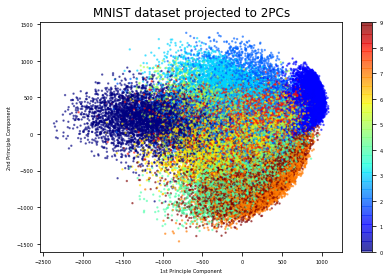

In [18]:
plt.scatter(Xtrain_pc2[:,0], Xtrain_pc2[:,1], c=y_train, cmap='jet', s=2, alpha=0.5)
plt.xlabel('1st Principle Component')
plt.ylabel('2nd Principle Component')
plt.title('MNIST dataset projected to 2PCs')
plt.colorbar()
save_fig('MNIST_2PC')

We now visualize the first 2 principle components.

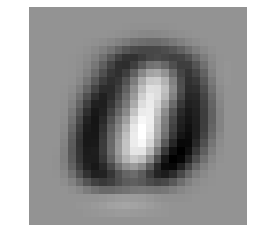

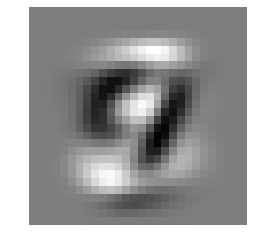

In [18]:
plot_digit(vT.T[:,0])
plt.show()
plot_digit(vT.T[:,1])

We now reconstruct the images from the top 2 principle components to see how well the images are reconstructed.

In [19]:
sigma_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
sigma_reconst[:sigma.shape[0], :sigma.shape[1]] = sigma
vT_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
vT_reconst[:vT.shape[0], :vT.shape[1]] = vT
Xtrain_recont = u.dot(sigma_reconst.dot(vT_reconst))+X_train_means

Saving figure Digits_reconst_2PC


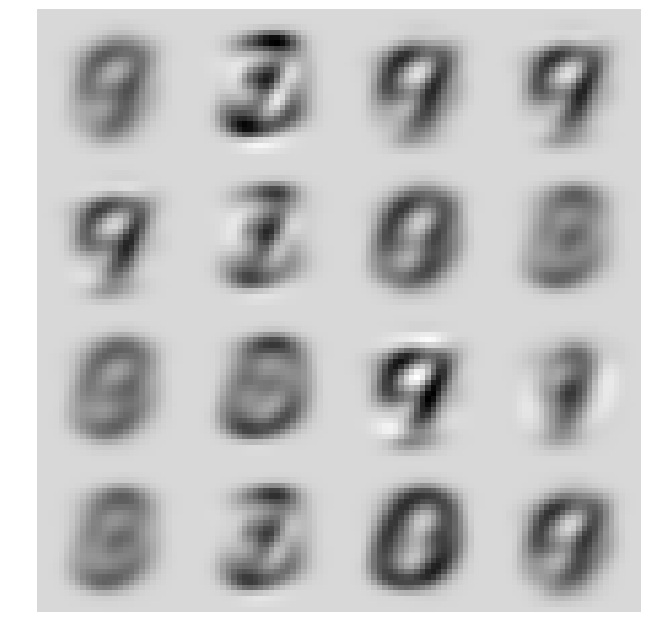

In [21]:
plt.figure(figsize=(9,9))
example_images = np.r_[Xtrain_recont[12:28]]
plot_digits(example_images, images_per_row=4)
save_fig("Digits_reconst_2PC")
plt.show()

### Top 3 Principle Components

In [15]:
u,d,vT = np.linalg.svd(Xtrain_center, full_matrices=False)

In [16]:
n_comp = 3
# Get matrix from d
sigma = np.diag(d)

#Get top n_comp components
sigma = sigma[:, :n_comp]
vT = vT[:n_comp, :]
print(sigma.shape)
print(u.shape)
print(vT.shape)

# if we want to calculate for the same matrix
Xtrain_pc3 = u.dot(sigma)
print(Xtrain_pc3.shape)

# if we were to use a new matrix and to only transform based on the PC of the earlier
Xtrain_pc3_2 = Xtrain_center.dot(vT.T)
print(Xtrain_pc3_2.shape)
#check if they are the same
print(np.allclose(Xtrain_pc3, Xtrain_pc3_2))

(784, 3)
(60000, 784)
(3, 784)
(60000, 3)
(60000, 3)
True


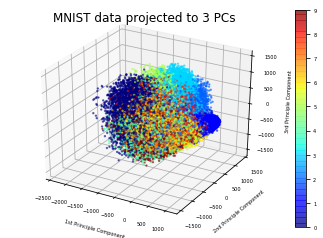

In [17]:
from mpl_toolkits.mplot3d import Axes3D 
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(Xtrain_pc3[:,0], Xtrain_pc3[:,1], Xtrain_pc3[:,2],  c=y_train, s=2, cmap='jet', alpha=0.5)
ax.set_xlabel('1st Principle Component')
ax.set_ylabel('2nd Principle Component')
ax.set_zlabel('3rd Principle Component')
ax.set_title('MNIST data projected to 3 PCs')
fig.colorbar(p)
fig.savefig('images/MNIST_3PC.png',dpi=500)

We now visualize the first three principle components.

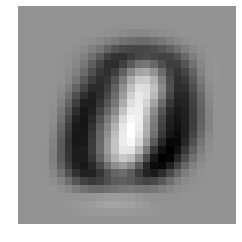

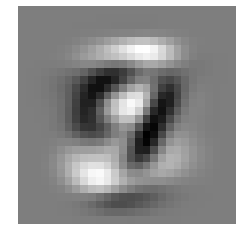

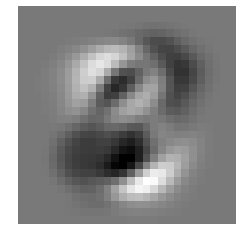

In [25]:
plot_digit(vT.T[:,0])
plt.show()
plot_digit(vT.T[:,1])
plt.show()
plot_digit(vT.T[:,2])

We now reconstruct the digit images with the to 3 PCs

In [26]:
sigma_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
sigma_reconst[:sigma.shape[0], :sigma.shape[1]] = sigma
vT_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
vT_reconst[:vT.shape[0], :vT.shape[1]] = vT
Xtrain_recont = u.dot(sigma_reconst.dot(vT_reconst))+X_train_means

Saving figure Digits_reconst_3PC


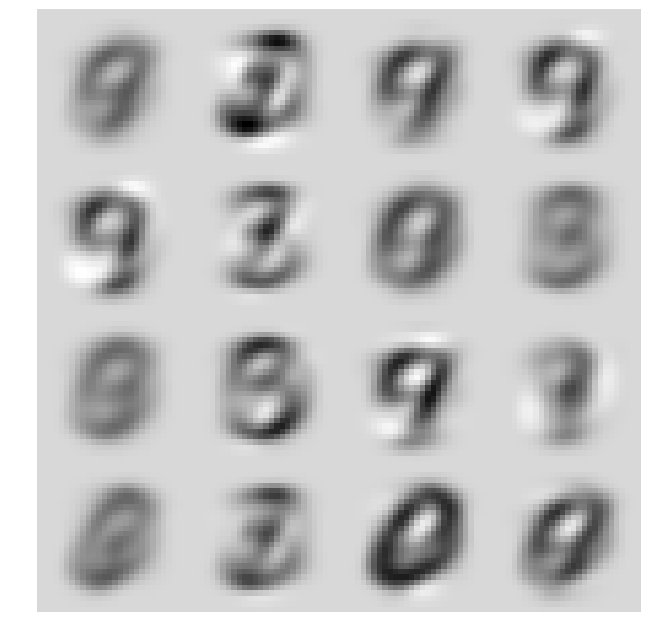

In [27]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.figure(figsize=(9,9))
example_images = np.r_[Xtrain_recont[12:28]]
plot_digits(example_images, images_per_row=4)
save_fig("Digits_reconst_3PC")
plt.show()

## Applying NN for 40, 80 and 200 PC
We go from 200 and decrease.
#### Top 200 PCs

In [15]:
u,d,vT = np.linalg.svd(Xtrain_center, full_matrices=False)

In [16]:
n_comp = 200
# Get matrix from d
sigma = np.diag(d)

#Get top n_comp components
sigma = sigma[:, :n_comp]
vT = vT[:n_comp, :]

# if we want to calculate for the same matrix
Xtrain_pc200 = u.dot(sigma)
Xtest_pc200 = (X_test-X_train_means).dot(vT.T)

In [17]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)  
classifier.fit(Xtrain_pc200, y_train)
ytilde = classifier.predict(Xtest_pc200)

0.9691


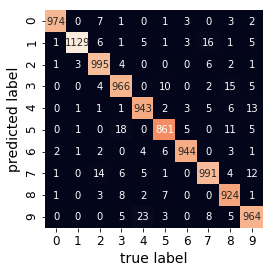

Text(88.68,0.5,'predicted label')

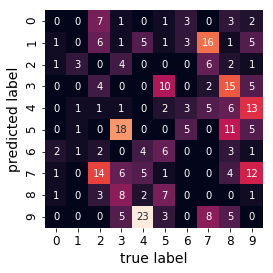

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
    
print(accuracy_score(y_test, ytilde))
mat = confusion_matrix(y_test, ytilde)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
np.fill_diagonal(mat, 0)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [30]:
sigma_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
sigma_reconst[:sigma.shape[0], :sigma.shape[1]] = sigma
vT_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
vT_reconst[:vT.shape[0], :vT.shape[1]] = vT
Xtrain_recont = u.dot(sigma_reconst.dot(vT_reconst))+X_train_means

Saving figure Digits_reconst_200PC


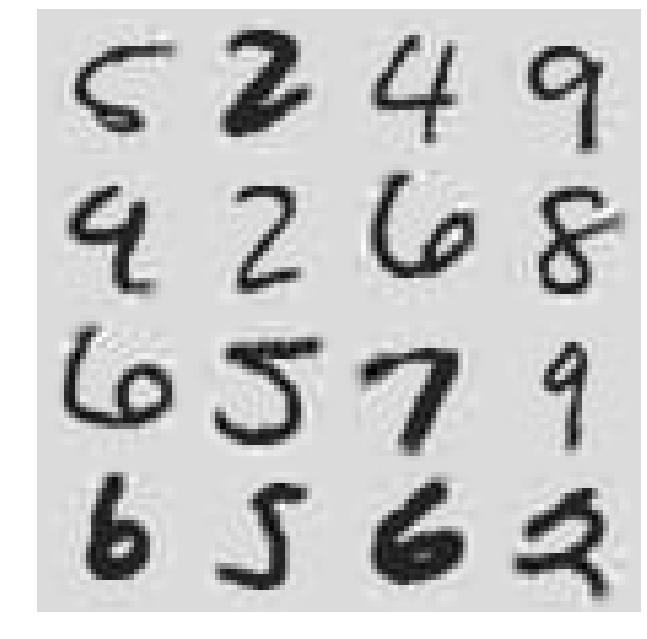

In [31]:
plt.figure(figsize=(9,9))
example_images = np.r_[Xtrain_recont[12:28]]
plot_digits(example_images, images_per_row=4)
save_fig("Digits_reconst_200PC")
plt.show()

#### Top 80 PCs

In [19]:
n_comp = 80

#Get top n_comp components
sigma = sigma[:, :n_comp]
vT = vT[:n_comp, :]

# if we want to calculate for the same matrix
Xtrain_pc80 = u.dot(sigma)
Xtest_pc80 = (X_test-X_train_means).dot(vT.T)

In [20]:
classifier = KNeighborsClassifier(n_neighbors=1)  
classifier.fit(Xtrain_pc80, y_train)
ytilde = classifier.predict(Xtest_pc80)

0.9729


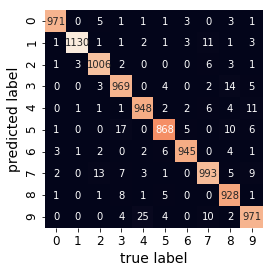

Text(88.68,0.5,'predicted label')

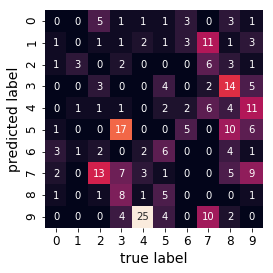

In [21]:
print(accuracy_score(y_test, ytilde))
mat = confusion_matrix(y_test, ytilde)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
np.fill_diagonal(mat, 0)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [33]:
sigma_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
sigma_reconst[:sigma.shape[0], :sigma.shape[1]] = sigma
vT_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
vT_reconst[:vT.shape[0], :vT.shape[1]] = vT
Xtrain_recont = u.dot(sigma_reconst.dot(vT_reconst))+X_train_means

Saving figure Digits_reconst_80PC


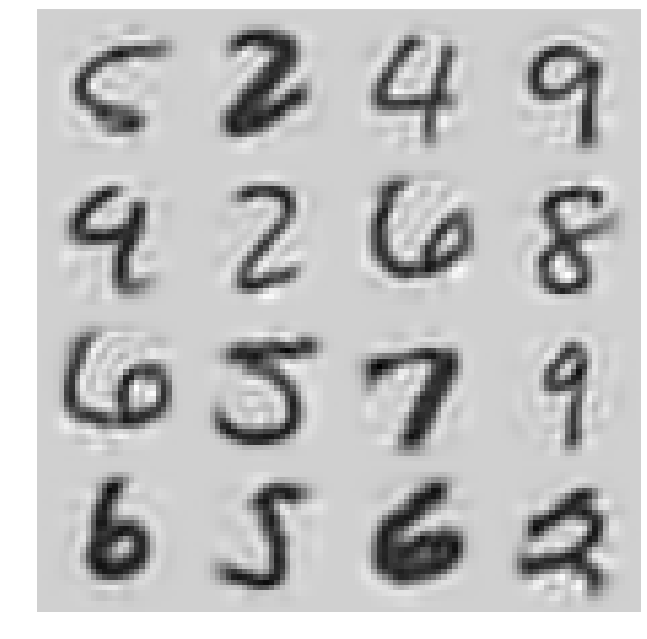

In [34]:
plt.figure(figsize=(9,9))
example_images = np.r_[Xtrain_recont[12:28]]
plot_digits(example_images, images_per_row=4)
save_fig("Digits_reconst_80PC")
plt.show()

#### Top 40 PCs

In [22]:
n_comp = 40

#Get top n_comp components
sigma = sigma[:, :n_comp]
vT = vT[:n_comp, :]

# if we want to calculate for the same matrix
Xtrain_pc40 = u.dot(sigma)
Xtest_pc40 = (X_test-X_train_means).dot(vT.T)

In [23]:
classifier = KNeighborsClassifier(n_neighbors=1)  
classifier.fit(Xtrain_pc40, y_train)
ytilde = classifier.predict(Xtest_pc40)

0.9735


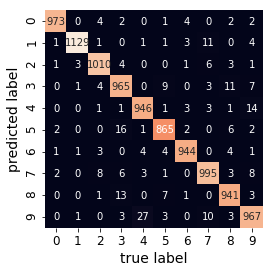

Text(88.68,0.5,'predicted label')

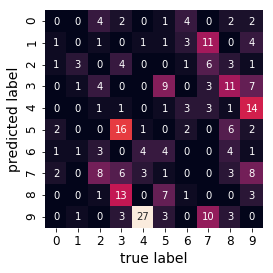

In [24]:
print(accuracy_score(y_test, ytilde))
mat = confusion_matrix(y_test, ytilde)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
np.fill_diagonal(mat, 0)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [41]:
sigma_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
sigma_reconst[:sigma.shape[0], :sigma.shape[1]] = sigma
vT_reconst = np.zeros((Xtrain_center.shape[1], Xtrain_center.shape[1]))
vT_reconst[:vT.shape[0], :vT.shape[1]] = vT
Xtrain_recont = u.dot(sigma_reconst.dot(vT_reconst))+X_train_means

Saving figure Digits_reconst_40PC


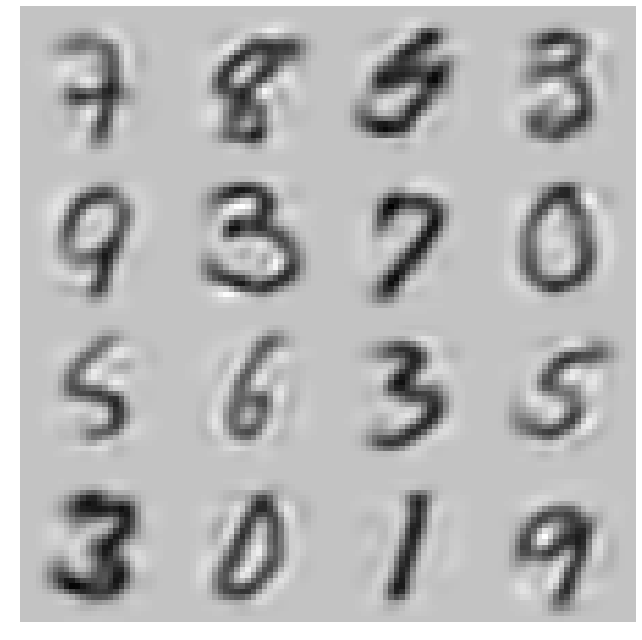

In [47]:
plt.figure(figsize=(9,9))
example_images = np.r_[Xtrain_recont[12:28]]
plot_digits(example_images, images_per_row=4)
save_fig("Digits_reconst_40PC")
plt.show()

## Choice of p most Principle Components

In [12]:
u,d,vT = np.linalg.svd(Xtrain_center, full_matrices=False)

In [13]:
d_cumsum = np.cumsum(np.square(d))
energy = d_cumsum/d_cumsum[-1]
mark_95 = np.argmax(energy>0.95)
mark_95

153

Saving figure energy_vs_numPC


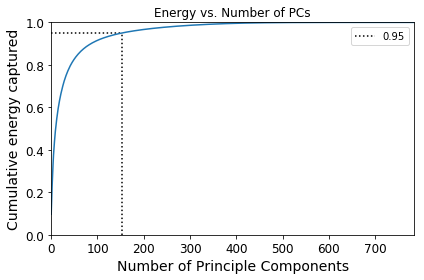

In [16]:
plt.xlim((0,784))
plt.ylim((0,1))
plt.xlabel('Number of Principle Components')
plt.ylabel('Cumulative energy captured')
plt.title('Energy vs. Number of PCs')
plt.hlines(y=0.95, xmin=0, xmax=153, linestyles='dotted', label='0.95')
plt.vlines(x=153, ymin=0, ymax=0.95, linestyles='dotted')
plt.legend()
plt.plot(energy)
save_fig('energy_vs_numPC')

## Nearest Neighbor over all $d \leq 784$

In [13]:
acc_dict = {}

In [14]:
u,d,vT = np.linalg.svd(Xtrain_center, full_matrices=False)
sigma = np.diag(d)

In [17]:
d_arr = np.array(range(784,0,-10))
accuracy = []
classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

for d in d_arr:
    if d not in acc_dict.keys():
        #Get top d components
        sigma = sigma[:, :d]
        vT = vT[:d, :]

        # if we want to calculate for the same matrix
        Xtrain_pcd = u.dot(sigma)
        Xtest_pcd = (X_test-X_train_means).dot(vT.T)

        classifier.fit(Xtrain_pcd, y_train)
        ytilde = classifier.predict(Xtest_pcd)

        acc_dict[d] = accuracy_score(y_test, ytilde)

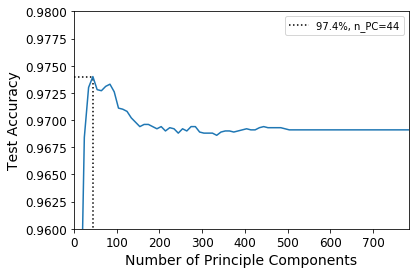

In [33]:
lists = sorted(acc_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.ylim((0.96, 0.98))
plt.hlines(y=0.974, xmin=0, xmax=44, label='97.4%, n_PC=44', linestyles='dotted')
plt.vlines(x=44, ymin=0.6, ymax=0.974, linestyles='dotted')
plt.xlim((0,784))
plt.legend()
plt.xlabel('Number of Principle Components')
plt.ylabel('Test Accuracy')
plt.show()
# save_fig("PC_vs_accuracy")

In [24]:
import operator
max(acc_dict.items(), key=operator.itemgetter(1))[0]

44

In [25]:
acc_dict[44]

0.97399999999999998